In [1]:
import rushd as rd
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from textwrap import wrap
from statannotations.Annotator import Annotator

import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [2]:
experimentdir = rd.datadir/'flow'/'2025.05.12_phospho-Ngn2_staining'

outputdir = rd.rootdir/'figures'/'Ngn2_Flow-Staining'

In [3]:
#rd.plot.plot_well_metadata(experimentdir/'metadata.yaml')

# Load Data

In [4]:
data_columns = ['GFP-A','Alexa Fluor™ 555-A']

df = rd.flow.load_csv_with_metadata(data_path=experimentdir/'csv',yaml_path=experimentdir/'metadata.yaml',columns=data_columns)

In [5]:
df = df.rename(columns={'Alexa Fluor™ 555-A':'Ngn2.x3HA-A'})
df['condition all'] = df['Ngn2'] + ' ' + df['infection'] + ' ' + df['small molecule']
df['condition'] = df['infection'] + ' ' + df['small molecule']

Get rid of negative values

In [6]:
#num = df._get_numeric_data()
data_columns = ['GFP-A','Ngn2.x3HA-A']

for i in np.arange(0,np.size(data_columns)):
    df = df.loc[df[data_columns[i]]>0]


# Gating

## iMN gate

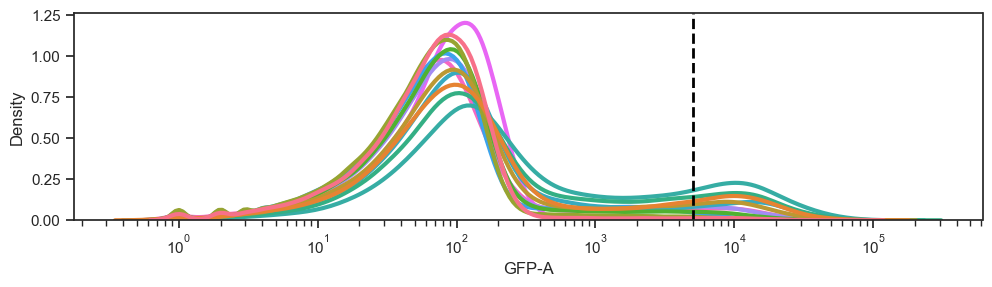

In [7]:
iMN_gate = 5 * 10**3 # Set gate

sns.set_theme(style="ticks",font_scale=1)

# Plot gate
plt.figure(figsize=(10,3))
g = sns.kdeplot(data=df,x='GFP-A',hue='condition all',log_scale=True,common_norm=False,linewidth=3,legend=False)
plt.axvline(x=iMN_gate,linestyle='--',color='black',linewidth=2)

#sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
plt.tight_layout()
plt.show()

## Ngn2 gate

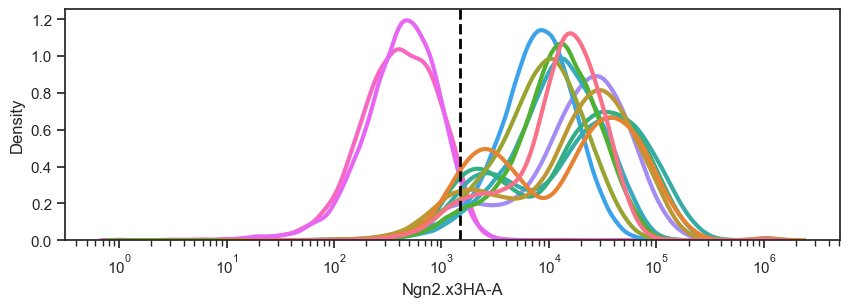

In [ ]:
Ngn2_gate = 1.5*10**3 # Set gate

sns.set_theme(style="ticks",font_scale=1)

# Plot gate
plt.figure(figsize=(10,3))
g = sns.kdeplot(data=df,x='Ngn2.x3HA-A',hue='condition all',log_scale=True,common_norm=False,linewidth=3,legend=False)
plt.axvline(x=Ngn2_gate,linestyle='--',color='black',linewidth=2)
#fig.legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
plt.show()

# Make summary statistics dataframe

In [11]:
groups = ['rep','Ngn2','infection','small molecule','condition','condition all','well']
summary_df = pd.concat([
    df.groupby(groups)['GFP-A'].apply(lambda x: np.size(x)).rename('Total Cell Count'),
    df.groupby(groups)['Ngn2.x3HA-A'].apply(scipy.stats.gmean).rename('Ngn2.x3HA MFI'),
    df.loc[df['Ngn2.x3HA-A']>Ngn2_gate].groupby(groups)['Ngn2.x3HA-A'].apply(scipy.stats.gmean).rename('Ngn2.x3HA+ MFI'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.mean(x > iMN_gate)*100).rename('(%) iMN\nof all cells'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > iMN_gate)).rename('iMN Yield'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > iMN_gate)/10000 * 100).rename('(%) iMN yield\nper MEF plated')
    ], axis=1)
summary_df = summary_df.reset_index()

data2plot = ['Ngn2.x3HA MFI','Ngn2.x3HA+ MFI','(%) iMN yield\nper MEF plated']

# Plotting Functions

In [ ]:
sns.set_theme(style="ticks",font_scale=1)

def custom_hist(xcat,data,order,hue,savetitle=None,palette='muted',gate=None,xlim=[10,5*10**4],title='4 dpi',width=6,height=2.5,common_norm=False):
    plt.figure(figsize=(width,height))
    if xcat in ['FSC-A','FSC-H']:
        log = False
        plt.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
    else:
        log = True
    g = sns.kdeplot(data=data,x=xcat,hue=hue,log_scale=log,common_norm=common_norm,hue_order=order[::-1],palette=palette, linewidth=2.5,fill=True,alpha=0.08)

    if gate is not None:
        plt.axvline(x=gate,linestyle='--',color='black',linewidth=2.5)


    plt.legend(order,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False)
    plt.xlim(xlim)
    plt.title(title)
    plt.xlabel(xcat)
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #plt.tight_layout()
    #g.savefig(outputdir/str(savetitle + '.png'),dpi=300)
    plt.savefig(outputdir/str(savetitle + '.svg'),dpi=300)
    plt.show()

In [ ]:
def custom_catplot2(xcat,ycat,data,savetitle,hue=None,hue_order=None,height=4,width=8,
                   xlabel_rot=0,xlabel='',plottitle='',order=None,palette=None,pairs=None,color=None,log=False,reps=None,jitter=0.08,capsize=0.22):


    if hue == None:
        dodge = False
    elif hue != None:
        dodge = 0.4

    plt.figure(figsize=(width,height))
    g = sns.pointplot(x=xcat,y=ycat,data=data,errorbar='se',join=False,capsize=capsize,
                      palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color,dodge=dodge,hue_order=hue_order)
    ax = plt.gca()
    
    if order != None:
        #labels = [ '\n'.join(wrap(l, 16)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None
    
    marker_list = ['o', '^', 's', 'D', 'P', 'X']
    if reps is not None:
        x_categories = order if order is not None else data[xcat].unique()
        hue_categories = hue_order if hue_order is not None else data[hue].unique() if hue is not None else [None]
        x_pos_map = {cat: i for i, cat in enumerate(x_categories)}

        for (j, rep) in enumerate(data[reps].unique()):
            rep_data = data[data[reps] == rep].copy()
            for i, x_val in enumerate(x_categories):
                for h_idx, h_val in enumerate(hue_categories):
                    # Filter data for this x and hue
                    subset = rep_data[
                        (rep_data[xcat] == x_val) &
                        ((rep_data[hue] == h_val) if hue else True)
                    ]

                    # Skip if no data
                    if subset.empty:
                        continue

                    # Compute center x position
                    base_x = x_pos_map[x_val]
                    category_spacing = 1  # Default spacing between categories (can adjust if you have wider bars or spacing tweaks)
                    max_dodge = 0.35 * category_spacing  # Maximum total dodge span

                    # Scale dodge by number of hue levels
                    if len(hue_categories) > 1:
                        step = max_dodge / (len(hue_categories) - 1)
                        offset = (h_idx - (len(hue_categories) - 1) / 2) * step
                    else:
                        offset = 0

                    # Add jitter
                    jitter = np.random.uniform(-jitter, jitter, size=len(subset))
                    x_vals = base_x + offset + jitter

                    ax.scatter(
                        x_vals, subset[ycat],
                        label=None,
                        marker=marker_list[j % len(marker_list)],
                        s=7**2,  # because size in scatter is area
                        edgecolor='white',
                        linewidth=0.4,
                        c=[palette[h_val]] if hue else palette,
                        zorder=10  # make sure it draws on top
                    )

    ymin, ymax = ax.get_ylim()
    #display(ymin,ymax)

    if log == True:
        ax.set_yscale('log')
    elif ymax > 1000:
        plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
    
    plt.ylim([0.75*data[ycat].min(),ymax*1.1])


    if pairs != None:
        annotator = Annotator(ax,pairs,data=data,x=xcat,y=ycat,order=order,hue=hue,hue_order=hue_order)
        annotator.configure(test='t-test_ind',text_format='star',loc='inside')
        annotator.apply_and_annotate()

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    
    if hue == None:
        plt.margins(x=0.3, y=0.3) # for some reason the plot is being weird and this makes it look better

    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[0:len(hue_order)], labels[0:len(hue_order)], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False)

    #plt.legend([],[], frameon=False)
    plt.xlabel(xlabel)
    plt.ylabel(ycat)
    plt.title(plottitle)
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #plt.tight_layout()
    plt.savefig(outputdir/str(savetitle + '.svg'),dpi=600)
    plt.show()

# Plot Results

In [14]:
sns.set_theme(style="ticks",font_scale=1)
palette = {'WT':'#ea7676','9SA':'#3d9eb0','No Color':'black','Secondary':'#BBBBBB'}

data2plot = ['Ngn2.x3HA MFI','Ngn2.x3HA+ MFI']
bar2plot = ['(%) iMN yield\nper MEF plated']
MFI2plot = ['Ngn2.x3HA MFI','Ngn2.x3HA+ MFI']
hists2plot = ['Ngn2.x3HA-A']

savedict = {'(%) iMN yield\nper MEF plated':'4dpi-yield',
            'Ngn2.x3HA MFI':'Ngn2-MFI',
            'Ngn2.x3HA+ MFI':'Ngn2-pos-MFI'}

Cassette Barplots and catplots

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL SDD none_WT vs. NIL SDD none_9SA: t-test independent samples, P_val:2.084e-03 t=-7.095e+00
NIL none_WT vs. NIL none_9SA: t-test independent samples, P_val:1.539e-01 t=-1.756e+00
NIL SDD PMA_WT vs. NIL SDD PMA_9SA: t-test independent samples, P_val:2.576e-04 t=-1.222e+01
NIL RIDD none_WT vs. NIL RIDD none_9SA: t-test independent samples, P_val:5.779e-04 t=-9.928e+00
NIL RIDD MEKi_WT vs. NIL RIDD MEKi_9SA: t-test independent samples, P_val:6.014e-02 t=-2.599e+00


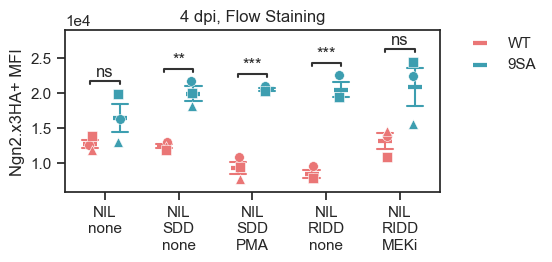

In [15]:
palette = {'WT':'#ea7676','9SA':'#3d9eb0','No Color':'black','Secondary':'#BBBBBB'}
MFI2plot = ['Ngn2.x3HA+ MFI']
order = ['NIL none','NIL SDD none','NIL SDD PMA','NIL RIDD none','NIL RIDD MEKi']
hue_order = ['WT','9SA']
pairs = [((cond, hue_order[0]), (cond, hue_order[1])) for cond in order]
for i in MFI2plot:
    savetitle = savedict[i]
    plottitle = '4 dpi, Flow Staining'
    custom_catplot2('condition',i,summary_df[summary_df.Ngn2.isin(hue_order)],savetitle,
                    plottitle=plottitle,
                    height=2.5,
                    width=5,
                    order=order,
                    hue='Ngn2',
                    hue_order=hue_order,
                    palette=palette,
                    reps='rep',
                    pairs=pairs)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD none_WT vs. NIL RIDD none_9SA: t-test independent samples, P_val:5.779e-04 t=-9.928e+00


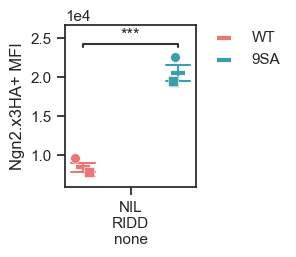

In [16]:
palette = {'WT':'#ea7676','9SA':'#3d9eb0','No Color':'black','Secondary':'#BBBBBB'}
MFI2plot = ['Ngn2.x3HA+ MFI']
pairs = [(('NIL RIDD none','WT'),('NIL RIDD none','9SA'))]

for i in MFI2plot:
    order = ['NIL RIDD none']
    slice = summary_df[(summary_df.Ngn2.isin(['WT','9SA'])) & (summary_df.condition.isin(order))]
    savetitle = 'RIDD-only_' + savedict[i]
    custom_catplot2('condition',i,slice,savetitle,
                    plottitle=None,
                    height=2.5,
                    width=1.75,
                    order=order,
                    hue='Ngn2',
                    hue_order=['WT','9SA'],
                    palette=palette,
                    reps='rep',capsize=0.1,pairs=pairs)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL SDD none_WT vs. NIL SDD PMA_WT: t-test independent samples, P_val:3.046e-02 t=3.282e+00
NIL SDD none_9SA vs. NIL SDD PMA_9SA: t-test independent samples, P_val:5.967e-01 t=-5.740e-01


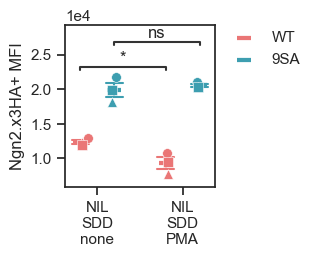

In [17]:
palette = {'WT':'#ea7676','9SA':'#3d9eb0','No Color':'black','Secondary':'#BBBBBB'}
MFI2plot = ['Ngn2.x3HA+ MFI']
pairs = [(('NIL SDD none','WT'),('NIL SDD PMA','WT')),(('NIL SDD none','9SA'),('NIL SDD PMA','9SA')),]

for i in MFI2plot:
    order = ['NIL SDD none','NIL SDD PMA']
    slice = summary_df[(summary_df.Ngn2.isin(['WT','9SA'])) & (summary_df.condition.isin(order))]
    savetitle = 'SDD-PMA-only_' + savedict[i]
    custom_catplot2('condition',i,slice,savetitle,
                    plottitle=None,
                    height=2.5,
                    width=2,
                    order=order,
                    hue='Ngn2',
                    hue_order=['WT','9SA'],
                    palette=palette,
                    reps='rep',capsize=0.2,pairs=pairs)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD none_WT vs. NIL RIDD MEKi_WT: t-test independent samples, P_val:2.158e-02 t=-3.660e+00
NIL RIDD none_9SA vs. NIL RIDD MEKi_9SA: t-test independent samples, P_val:9.175e-01 t=-1.103e-01


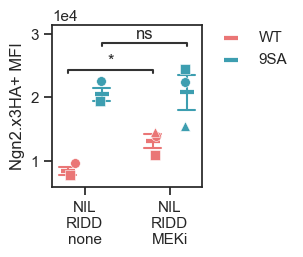

In [18]:
palette = {'WT':'#ea7676','9SA':'#3d9eb0','No Color':'black','Secondary':'#BBBBBB'}
MFI2plot = ['Ngn2.x3HA+ MFI']
pairs = [(('NIL RIDD none','WT'),('NIL RIDD MEKi','WT')),(('NIL RIDD none','9SA'),('NIL RIDD MEKi','9SA')),]

for i in MFI2plot:
    order = ['NIL RIDD none','NIL RIDD MEKi']
    slice = summary_df[(summary_df.Ngn2.isin(['WT','9SA'])) & (summary_df.condition.isin(order))]
    savetitle = 'RIDD-MEKi-only_' + savedict[i]
    custom_catplot2('condition',i,slice,savetitle,
                    plottitle=None,
                    height=2.5,
                    width=2,
                    order=order,
                    hue='Ngn2',
                    hue_order=['WT','9SA'],
                    palette=palette,
                    reps='rep',capsize=0.2,pairs=pairs)

# Histograms

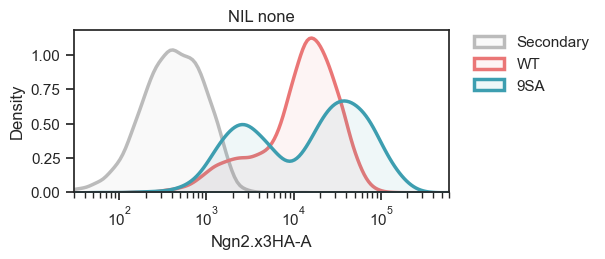

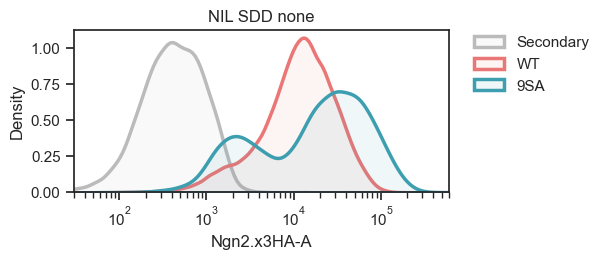

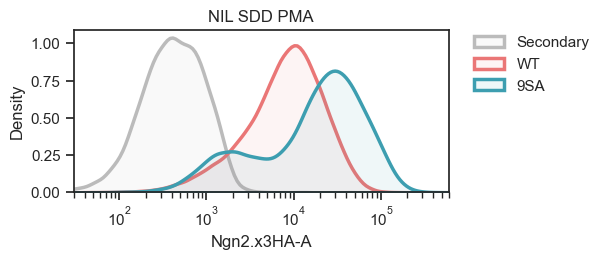

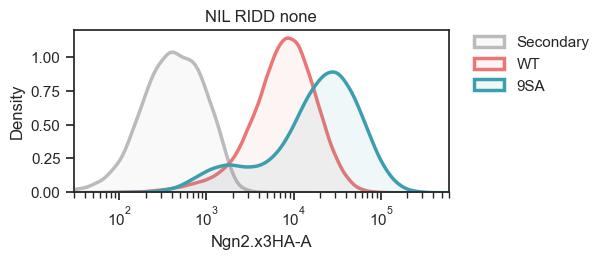

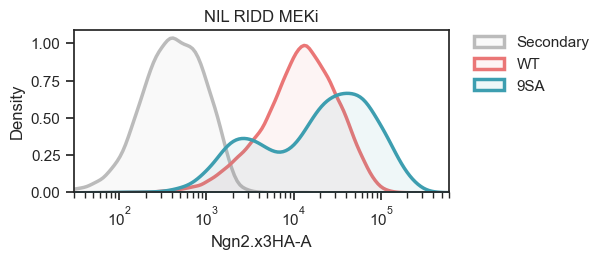

In [19]:
palette = {'WT':'#ea7676','9SA':'#3d9eb0','No Color':'black','Secondary':'#BBBBBB'}

for i in ['NIL none','NIL SDD none','NIL SDD PMA','NIL RIDD none','NIL RIDD MEKi']:
    savetitle = i+'_histogram'
    plottitle = i
    slice = df[(df.condition == i) | (df.Ngn2 == 'Secondary')]
    custom_hist(xcat='Ngn2.x3HA-A',data=slice,order=['Secondary','WT','9SA'],hue='Ngn2',savetitle=savetitle,xlim=[30,6*10**5],palette=palette,width=5,height=2.5,title=plottitle)

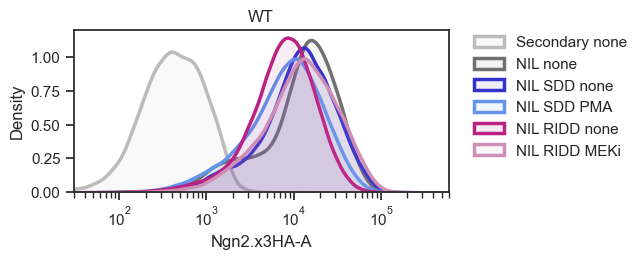

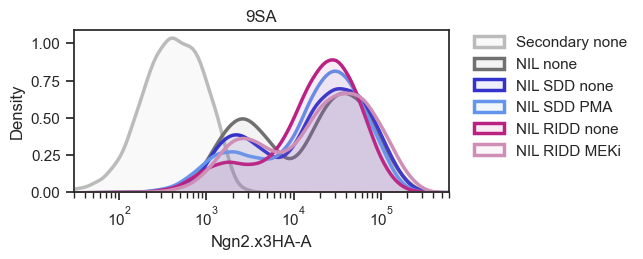

In [20]:
palette_reprogramming = {'NIL none':'#707070',
                         'NIL SDD none':'#3333cc','NIL SDD PMA':'#6495ed',
                         'NIL RIDD none':'#ba2182','NIL RIDD MEKi':"#cf8eb6",
                         'Secondary none':'#BBBBBB'}



order = ['Secondary none','NIL none','NIL SDD none','NIL SDD PMA','NIL RIDD none','NIL RIDD MEKi']
for i in ['WT','9SA']:
    savetitle = i+'_histogram'
    plottitle = i
    slice = df[(df.Ngn2 == i) | (df.condition == 'Secondary none')]
    custom_hist(xcat='Ngn2.x3HA-A',data=slice,order=order,hue='condition',
                savetitle=savetitle,xlim=[30,6*10**5],palette=palette_reprogramming,width=5,height=2.5,title=plottitle)